# Sofa notes

The HRTFs are provided as impulse responses (IRs) with the length of 512 samples at a sampling rate of 44.1 kHz.

360° azimuthal range in steps of 5° and a constant distance of 1.4 m.

https://zenodo.org/records/3928297 - Page for 360 HRTF

# Example for viewing .sofa files

In [31]:
import sofa
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import scipy
from scipy import signal
import os

import librosa
import glob
from IPython.display import Audio
import soundfile as sf

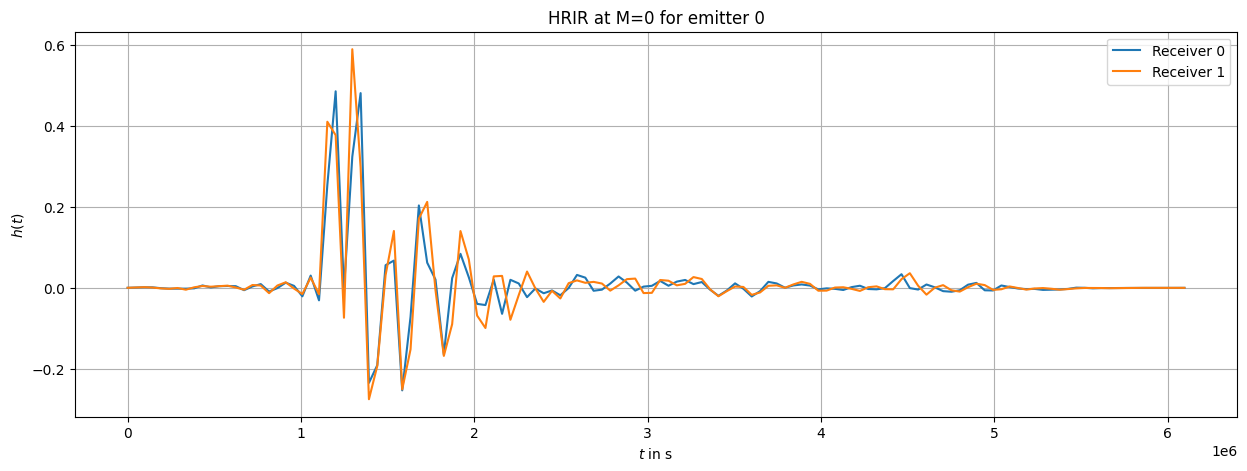

In [2]:

def plot_coordinates(coords, title):
    x0 = coords
    n0 = coords
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')
    q = ax.quiver(x0[:, 0], x0[:, 1], x0[:, 2], n0[:, 0],
                  n0[:, 1], n0[:, 2], length=0.1)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title(title)
    return q


HRTF_path = "Resources/HRTF/HRIR_CIRC360RM.sofa"
HRTF = sofa.Database.open(HRTF_path)
# HRTF.Metadata.dump()

# plot Source positions
source_positions = HRTF.Source.Position.get_values(system="spherical")
# plot_coordinates(source_positions, 'Source positions');

# plot Data.IR at M=5 for E=0
measurement = 0
emitter = 0
legend = []

t = np.arange(0,HRTF.Dimensions.N)*HRTF.Data.SamplingRate.get_values(indices={"M":measurement})

plt.figure(figsize=(15, 5))
for receiver in np.arange(HRTF.Dimensions.R):
    plt.plot(t, HRTF.Data.IR.get_values(indices={"M":measurement, "R":receiver, "E":emitter}))
    legend.append('Receiver {0}'.format(receiver))
plt.title('HRIR at M={0} for emitter {1}'.format(measurement, emitter))
plt.legend(legend)
plt.xlabel('$t$ in s')
plt.ylabel(r'$h(t)$')
plt.grid()

plt.show()

HRTF.close()

In [33]:
def generate_multi_sine_wave(duration, frequencies, amplitudes, sampling_rate):
    t = np.arange(0, duration, 1/sampling_rate)
    signal = np.array(np.sum([amplitude * np.sin(2 * np.pi * frequency * t) for frequency, amplitude in zip(frequencies, amplitudes)], axis=0))
    return t, signal

def binauralize(sig_L, sig_R, angle):
    HRTF = sofa.Database.open(HRTF_path)
    meas = HRTF.Data.IR.get_values(indices={"M":angle})
    bin_L = signal.fftconvolve(sig_L, meas[0])
    bin_R = signal.fftconvolve(sig_R, meas[1])

    bin_stereo = np.vstack((bin_L, bin_R)).astype(np.float32)

    return bin_stereo

def plot_HRIR(HRTF, angle):

    HRTF = HRTF

    t = np.arange(0,HRTF.Dimensions.N)*HRTF.Data.SamplingRate.get_values(indices={"M":angle})

    plt.figure(figsize=(15, 5))
    for receiver in np.arange(HRTF.Dimensions.R):
        plt.plot(t, HRTF.Data.IR.get_values(indices={"M":angle, "R":receiver, "E":emitter}))
        legend.append('Receiver {0}'.format(receiver))
    plt.title('HRIR at M={0} for emitter {1}'.format(angle, emitter))
    plt.legend(legend)
    plt.xlabel('$t$ in s')
    plt.ylabel(r'$h(t)$')
    plt.grid()

    plt.show()





HRTF = sofa.Database.open(HRTF_path)
angle = 90


mp3 , sr = librosa.load("Resources/Soundfiles/Wow_quest_complete.mp3", sr=44100)
_ , sine_1k = generate_multi_sine_wave(4, [300], [1], 44100)


bin_stereo = binauralize(mp3, mp3, angle)
plot_HRIR(HRTF, angle)
Audio(bin_stereo, rate=44100)

# Generate raw sine waves in stereo

In [22]:
duration = 5
fs = 44100
freq = 15000

t , sine = generate_multi_sine_wave(duration, [freq], [1], fs)

sine_stereo = np.vstack((sine, sine)).astype(np.float32)

scipy.io.wavfile.write(f"Resources/Soundfiles/sine_{freq}Hz_stereo.wav", fs, sine_stereo.transpose())

# Convert sines to binaural audio using set angles

In [35]:
list_stereo = glob.glob("Resources/Soundfiles/*.wav")
names = [os.path.basename(x) for x in list_stereo]

angles = [0, 25, 50, 75, 90, 115, 135, 155, 180, 360-155, 360-135, 360-115, 360-90, 360-75, 360-50, 360-25]

for name in names:
    for angle in angles:
        file = librosa.load("Resources/Soundfiles/" + name, mono=False, sr=None)

        bin_file = binauralize(file[0][0], file[0][1], angle)

        scipy.io.wavfile.write(f"Resources/Soundfiles/Binaurals/" + "binaural_" + f"{angle}_" + name, fs, bin_file.transpose())
    
